Critical Path: A -> B -> D -> F -> G


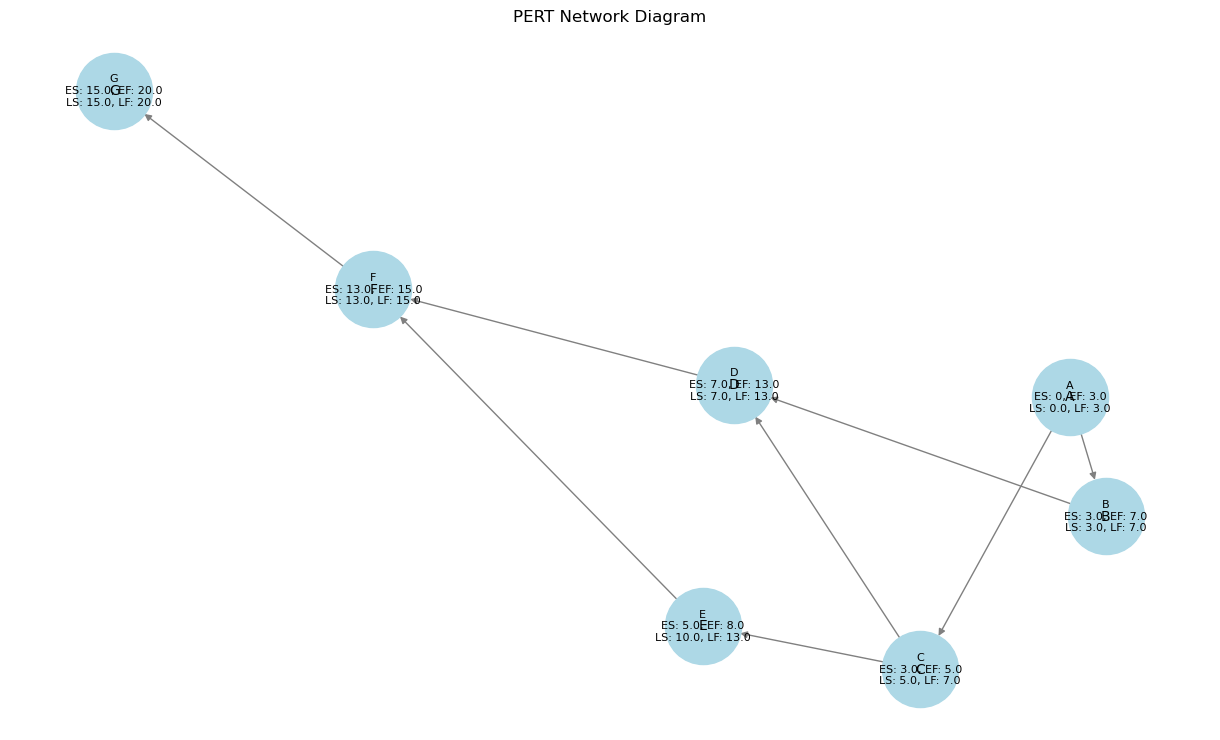

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

class Task:
    def __init__(self, name, optimistic, most_likely, pessimistic):
        self.name = name
        self.optimistic = optimistic
        self.most_likely = most_likely
        self.pessimistic = pessimistic
        self.duration = (optimistic + 4 * most_likely + pessimistic) / 6  # PERT formula
        self.early_start = 0
        self.early_finish = 0
        self.late_start = float('inf')
        self.late_finish = float('inf')
        self.successors = []

class PERT:
    def __init__(self, tasks, dependencies):
        self.tasks = {name: Task(name, *durations) for name, durations in tasks.items()}
        self.dependencies = dependencies
        self.build_graph()

    def build_graph(self):
        for task, deps in self.dependencies.items():
            for dep in deps:
                self.tasks[dep].successors.append(self.tasks[task])

    def forward_pass(self):
        for task in self.tasks.values():
            if not self.dependencies[task.name]:
                task.early_start = 0
                task.early_finish = task.duration

        for task in sorted(self.tasks.values(), key=lambda t: t.early_start):
            for succ in task.successors:
                succ.early_start = max(succ.early_start, task.early_finish)
                succ.early_finish = succ.early_start + succ.duration

    def backward_pass(self):
        max_finish = max(task.early_finish for task in self.tasks.values())
        for task in self.tasks.values():
            if not task.successors:
                task.late_finish = max_finish
            task.late_start = task.late_finish - task.duration

        for task in sorted(self.tasks.values(), key=lambda t: -t.early_finish):
            for succ in task.successors:
                task.late_finish = min(task.late_finish, succ.late_start)
                task.late_start = task.late_finish - task.duration

    def find_critical_path(self):
        return [task.name for task in self.tasks.values() if task.early_start == task.late_start]

    def run(self):
        self.forward_pass()
        self.backward_pass()
        return self.find_critical_path()

    def visualize_network(self):
        G = nx.DiGraph()
        for task in self.tasks.values():
            G.add_node(task.name, label=f"{task.name}\nES: {task.early_start}, EF: {task.early_finish}\nLS: {task.late_start}, LF: {task.late_finish}")
        for task in self.tasks.values():
            for succ in task.successors:
                G.add_edge(task.name, succ.name)

        pos = nx.spring_layout(G)
        labels = {node: data['label'] for node, data in G.nodes(data=True)}
        plt.figure(figsize=(12, 7))
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', edge_color='gray', font_size=10)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
        plt.title("PERT Network Diagram")
        plt.show()

if __name__ == "__main__":
    tasks = {
        'A': (1, 3, 5),  # Optimistic, Most Likely, Pessimistic
        'B': (2, 4, 6),
        'C': (1, 2, 3),
        'D': (3, 6, 9),
        'E': (2, 3, 4),
        'F': (1, 2, 3),
        'G': (2, 5, 8)
    }

    dependencies = {
        'A': [],
        'B': ['A'],
        'C': ['A'],
        'D': ['B', 'C'],
        'E': ['C'],
        'F': ['D', 'E'],
        'G': ['F']
    }

    pert = PERT(tasks, dependencies)
    critical_path = pert.run()
    print("Critical Path:", " -> ".join(critical_path))
    pert.visualize_network()
